# Nice Ride MN Exploratory Data Analysis

TODO: description / intro...

Nice Ride MN shares their [historical system data](https://www.niceridemn.org/data/)

In [98]:
# Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Matplotlib settings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set()

# Bokeh settings
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, Circle, HoverTool, ColorBar, LinearColorMapper, CustomJS, Slider
from bokeh.palettes import Viridis256, brewer
from bokeh.tile_providers import CARTODBPOSITRON_RETINA
from bokeh.models.widgets import Panel, Tabs
from bokeh.layouts import column
fig_height = 500
fig_width = 800
output_notebook()

Loading BokehJS ...

## Data Loading and Cleaning

First, let's load the data and take a look at the data to see if it needs any cleaning.

In [2]:
# Load data
stations = pd.read_csv('../input/Nice_Ride_2017_Station_Locations.csv')
trips = pd.read_csv('../input/Nice_ride_trip_history_2017_season.csv')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Show some of the stations data
stations.sample(n=5)

,Number,Name,Latitude,Longitude,Total docks
101,30104,Logan Park,44.998820,-93.252760,23
119,30122,Broadway Street N & 4th Street E,44.949650,-93.084500,19
49,30050,2nd Ave S & S 3rd Street,44.979740,-93.265990,27
18,30018,MCAD,44.957214,-93.274981,17
156,30159,Fort Snelling State Park,44.890527,-93.182370,19


In [ ]:
# Print info about each column
for col in stations:
    print('\n',col,'\nNulls:',stations[col].isnull().sum(),'\n',stations[col].describe())

The stations dataset looks pretty clean - no missing values, and the latitude, longitude, and number of docks loaded as expected.  The only anomaly was that the last station ID number was a string ('NRHQ'), while all the others were integers.  But that's fine - pandas will just treat that column as a categorical object, which is what we want anyway.  

What about the trip data?

In [ ]:
# Show some of the trip data
trips.sample(n=5)

In [ ]:
# Print info about each column
for col in trips:
    print('\n',col,'\nNulls:',trips[col].isnull().sum(),'\n',trips[col].describe())

The trips dataset looks pretty clean too.  The only anomalies I noticed were that there was a weird third Account type, and the dates were loaded as objects (instead of dates).

The possible types of accounts are "Member", "Casual" (which presumably just means non-member), and "Inconnu" (which I assume represents ["unknown"](https://en.wiktionary.org/wiki/inconnu#French) and not [the fish](https://en.wiktionary.org/wiki/inconnu#English)!).  But there were only two entries w/ an account type of "Inconnu", so we'll just set those entries to be "Casual" so that we only have members and non-members.

In [ ]:
# Plot types of accounts in the trips dataset
ax = sns.countplot(x='Account type', data=trips)
plt.title('Account types')
for p in ax.patches:
    x = p.get_bbox().get_points()[:,0]
    y = p.get_bbox().get_points()[1,1]
    ax.annotate('%d' % (y), (x.mean(), y), 
                ha='center', va='bottom')
plt.show()

In [4]:
# Set "Inconnu" memberships to "Casual"
trips.loc[trips['Account type']=='Inconnu', 'Account type'] = 'Casual'

Another small probem with the trips datset was that the trip start and end dates were loaded as generic objects, instead of dates.  Since we'll want to work with them as date/times, we'll convert them to the datetime datatype:

In [5]:
# Convert start and end times to datetime
for col in ['End date', 'Start date']:
    trips[col] = pd.to_datetime(trips[col])

## Station Locations

Let's plot the Nice Ride station locations on a map.  We'll use [Bokeh](https://bokeh.pydata.org/en/latest/) to display a map of the station locations.  To plot them on a map, however, we'll first have to transform the station locations from latitude+longitude coordinates to [Mercator (UTM) coordinates](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system), and make a function which generates a plot of points on the map.

In [99]:
def lat_to_mercY(lat):
    """Convert Latitude to Mercator Y"""
    return np.log(np.tan(np.pi/4+np.radians(lat)/2))*6378137.0

def lon_to_mercX(lon):
    """Convert Longitude to Mercator X"""
    return np.radians(lon)*6378137.0

def MapPoints(lat, lon, size=10, color="green", alpha=0.8, 
              padding=0.1, tooltips=None, title=None, 
              width=None, height=None, clims=None,
              palette=Viridis256, symmetric_color=False):
    """Bokeh plot of points overlayed on a map"""
    
    # Convert lat,lon to UTM coordinates
    X = lon_to_mercX(lon)
    Y = lat_to_mercY(lat)
    
    # Set marker sizes
    if type(size) is int or type(size) is float:
        size = size*np.ones(len(lat))
    
    # Data source table for Bokeh
    source = ColumnDataSource(data=dict(
        X = X,
        Y = Y,
        size = size
    ))
    
    # Color limits
    if type(color) is not str:
        if clims is None:
            if symmetric_color:
                cmin = -max(abs(color))
                cmax = max(abs(color))
            else:
                cmin = min(color)
                cmax = max(color)
        else:
            cmin = clims[0]
            cmax = clims[1]
            
    # Set marker colors
    if type(color) is not str: #map colors to a colormap
        source.add(color, 'color') #add to source table
        mapper = LinearColorMapper(palette=palette, 
                                   low=cmin, 
                                   high=cmax)
        color = {'field': 'color', 'transform': mapper}
            
    # Plot the points
    p = figure(tools="pan,wheel_zoom,reset,hover,save", 
               active_scroll="wheel_zoom")
    p.add_tile(CARTODBPOSITRON_RETINA) #set background map
    p.circle('X', 'Y', source=source, size='size', 
             fill_color=color, fill_alpha=alpha, 
             line_color=None) #plot each station
    p.axis.visible = False
    
    # Colorbar
    if type(color) is not str:
        color_bar = ColorBar(color_mapper=mapper, 
                             location=(0, 0))
        p.add_layout(color_bar, 'right')
        
    # Tool tips
    if tooltips is not None:
        for T in tooltips: #add to Bokeh data source
            source.add(T[1].values.tolist(), name=T[0])
        hover = p.select_one(HoverTool) #set hover values
        hover.tooltips=[(T[0], "@"+T[0]) for T in tooltips]
        
    # Title
    if title is not None:
        p.title.text = title
        
    # Figure height
    if height is not None:
        p.plot_height = height
        
    # Figure width
    if width is not None:
        p.plot_width = width
    
    return p, source

In [50]:
# On hover, show Station name
tooltips = [("Station", stations['Name'])]

# Plot the stations
p, _ = MapPoints(stations.Latitude, stations.Longitude, 
                 title="Nice Ride Station Locations",
                 tooltips=tooltips,
                 height=fig_height, width=fig_width)

show(p)

Looks like most of the stations are scattered around Minneapolis, but there's also a cluster in downtown St. Paul, and several stations along University Ave and Grand Ave, which connect Minneapolis and St. Paul.

## Number of Bike Docks per Station

Each station has a certain number of docks which people can rent bikes from or return them to at the end of their rentals.  How many docks do Nice Ride stations usually have?  We can plot a histogram of the number of docks at each station to get an idea of that distribution.

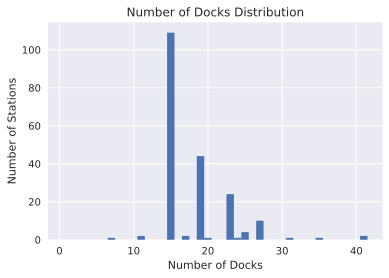

In [51]:
# Plot histogram of # docks at each station 
plt.figure()
plt.hist(stations['Total docks'], 
         bins=np.arange(0.5, 42.5, 1.))
plt.ylabel('Number of Stations')
plt.xlabel('Number of Docks')
plt.title('Number of Docks Distribution')
plt.show()

It looks like 15 is the standard station size, but with additional 4-dock add-ons (since there's also a bunch of stations with 19 docks, then less with 23, etc).  If the docks are most available/cheapest with 15-plus-increments-of-4 docks, then we'll have to take that into consideration later on, when we try to optimize the number of docks at each station.

Which stations have what number of docks, and how are those docks distributed geographically?  We can again plot the station locations, but now we'll also use the color and size of the station marker to indicate how many docks are at that station.

In [52]:
# On hover, show Station name and the number of docks
tooltips = [("Station", stations['Name']), 
            ("Docks", stations['Total docks'])]

# Plot the stations
p, _ = MapPoints(stations.Latitude, stations.Longitude, 
                 tooltips=tooltips, color=stations['Total docks'],
                 size=4*np.sqrt(stations['Total docks']/np.pi),
                 title="Number of Docks at each Station",
                 height=fig_height, width=fig_width)

show(p)

## Station Demand

Let's also take a look at the demand at each station.  What I mean by that is the number of bikes which users take from each station and leave at each station.  By grouping by the station name and counting, we can find how many trips have left from or ended at each station.

In [53]:
# Count incoming and outgoing trips for each station
demand_df = pd.DataFrame({'Outbound trips': trips.groupby('Start station').size(),
                          'Inbound trips': trips.groupby('End station').size()
                      })
demand_df['Name'] = demand_df.index
sdf = stations.merge(demand_df, on='Name')

How many trips are started from each station?  We'll take a look at the distribution (as a histogram) and then plot the number of trips started from each station on a map.

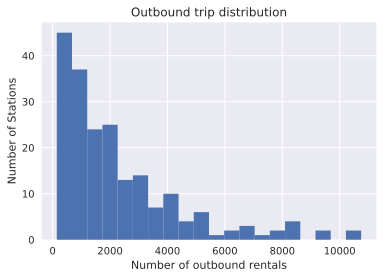

In [54]:
# Plot num trips started from each station 
plt.figure()
plt.hist(sdf['Outbound trips'], bins=20)
plt.ylabel('Number of Stations')
plt.xlabel('Number of outbound rentals')
plt.title('Outbound trip distribution')
plt.show()

And the number of trips which *end* at each station?

In [ ]:
# Plot num trips started from each station 
plt.figure()
plt.hist(sdf['Inbound trips'], bins=20)
plt.ylabel('Number of Stations')
plt.xlabel('Number of inbound rentals')
plt.title('Inbound trip distribution')
plt.show()

Nice Ride MN has to re-distribute bikes from stations which have extra bikes to stations which don't have enough.  Stations which have more rides ending at that station than starting there will end up with extra bikes, and Nice Ride will have to re-distribute those extra bikes to the stations which are more empty!  What does this distribution look like? That is, which stations have more rides ending at that station than starting there, or vice versa? 

Number of outbound trips: 460718
Number of inbound trips: 460718


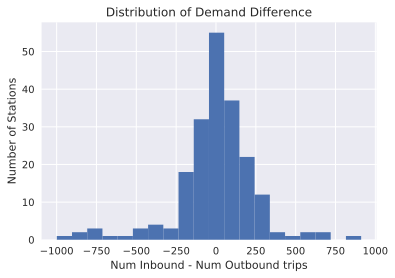

In [55]:
# Compute the DIFFERENCE between #incoming and #outgoing trips
sdf['demand_diff'] = sdf['Inbound trips']-sdf['Outbound trips']

# Sanity / valid data check
print('Number of outbound trips: %d' % (sdf['Outbound trips'].sum()))
print('Number of inbound trips: %d' % (sdf['Inbound trips'].sum()))

# Plot histogram of difference in demand
plt.figure()
plt.hist(sdf['demand_diff'], bins=20)
plt.ylabel('Number of Stations')
plt.xlabel('Num Inbound - Num Outbound trips')
plt.title('Distribution of Demand Difference')
plt.show()

Luckily most stations have about as many rides ending there as starting from that station.  However, there are definitely a few stations which are imbalanced!  That is, there are some stations which have more rides which end there than start there, or vice-versa.  But which ones are those?

We can plot these distributions on a map to see which are the imbalanced stations.  We'll use Bokeh to plot the number of outbound trips, inbound trips, and the difference in demand in three separate tabs.  The color and area of the circles represent the vaue (number of outbound trips, inbound trips, or the difference) in the corresponding tab.  For the "Difference", the size of the circle represents the *absolute* difference (so we can see which stations are the most imbalanced, and the color tells us in which direction they are imbalanced).

In [100]:
# On hover, show station info
tooltips = [("Station", sdf['Name']), #show on hover
            ("Docks", sdf['Total docks']), 
            ("Num_Outbound", sdf['Outbound trips']),
            ("Num_Inbound", sdf['Inbound trips']),
            ("Inbound_minus_Outbound", sdf['demand_diff'])]

# Outbound trips 
p1, _ = MapPoints(sdf.Latitude, sdf.Longitude, 
                  tooltips=tooltips, color=sdf['Outbound trips'],
                  size=0.3*np.sqrt(sdf['Outbound trips']/np.pi),
                  title="Number of Outbound Trips",
                  height=fig_height, width=fig_width)
tab1 = Panel(child=p1, title="Outbound")

# Inbound trips
p2, _ = MapPoints(sdf.Latitude, sdf.Longitude, 
                  tooltips=tooltips, color=sdf['Inbound trips'],
                  size=0.3*np.sqrt(sdf['Inbound trips']/np.pi),
                  title="Number of Inbound Trips",
                  height=fig_height, width=fig_width)
tab2 = Panel(child=p2, title="Inbound")

# Difference in demand (Inbound - Outbound) trips
p3, _ = MapPoints(sdf.Latitude, sdf.Longitude, 
                  tooltips=tooltips, color=sdf['demand_diff'],
                  size=1*np.sqrt(np.abs(sdf['demand_diff'])/np.pi),
                  title="Inbound - Outbound Trips",
                  palette=brewer['Spectral'][11], #divergent palette
                  symmetric_color=True, #centered @ 0
                  height=fig_height, width=fig_width)
tab3 = Panel(child=p3, title="Difference")

show(Tabs(tabs=[tab1, tab2, tab3]))

In the "Difference" tab, we can immediately identify some problem stations.  There are some stations at which far more people are ending their trips than starting them (e.g. the station at Lake St & Knox Ave, at the northeast corner of Bde Maka Ska, or the Minnehaha Park station).  There are also stations at which far more people are *starting* their trips than ending them (e.g. the stations at Coffman Union and Wiley Hall on the Univeristy of Minnesota campus).  But the majority of stations have about as many inbound as outbound rides (e.g. the two stations by Como Lake, which you can barely see on the differences map!).  

Plotting the difference in demand by location also reveals an interesting rental flow pattern: it appears that, on average, more rides start from downtown Minneapolis or the U of M campus and go away from downtown.  Notice how there's a lot of large blue circles (stations with more outbound rides) clustered around downtown Minneapolis, but most of the large red circles (stations with more inbound rides) lie away from downtown, and tend to be "destinations" and parks (such as Minnehaha Park, Bde Maka Ska, Logan Park, and North Mississippi Regional Park)

Is this difference in demand going to be a problem for Nice Ride?  Ideally, Nice Ride will want to have more docks at stations where there is large difference between the number of incoming and outgoing rides.  This is because if more rides are starting at a given station than ending there, the number of bikes at that station will decrease as the day goes on.  So, there needs to be enough docks at that station to hold enough bikes so the station isn't empty by the end of the day!  On the other hand, if more rides are *ending* at a station than are beginning there, all the docks at that station will fill up and people won't be able to end their rides there!  So those stations must have enough docks to absorb the amount of incoming traffic over the course of a day.

Stations which have a good balance of the number of rides coming in to the number of rides going out don't need quite as many docks - because about as many bikes are being taken from that station as are being left there.  Of course, there's also the issue of time - some stations may see different demand depending on the time of day, week, or season - but we'll get to that later. With a good match of the number of docks at each station to the difference between incoming and outgoing trips, Nice Ride won't have to spend as much time during prime riding hours re-distributing bikes from low-demand stations (with extra unused bikes) to high-demand stations (with not enough bikes!).  How well does this distribution of demand differences match up with the distribution of the number of docks at each station? 

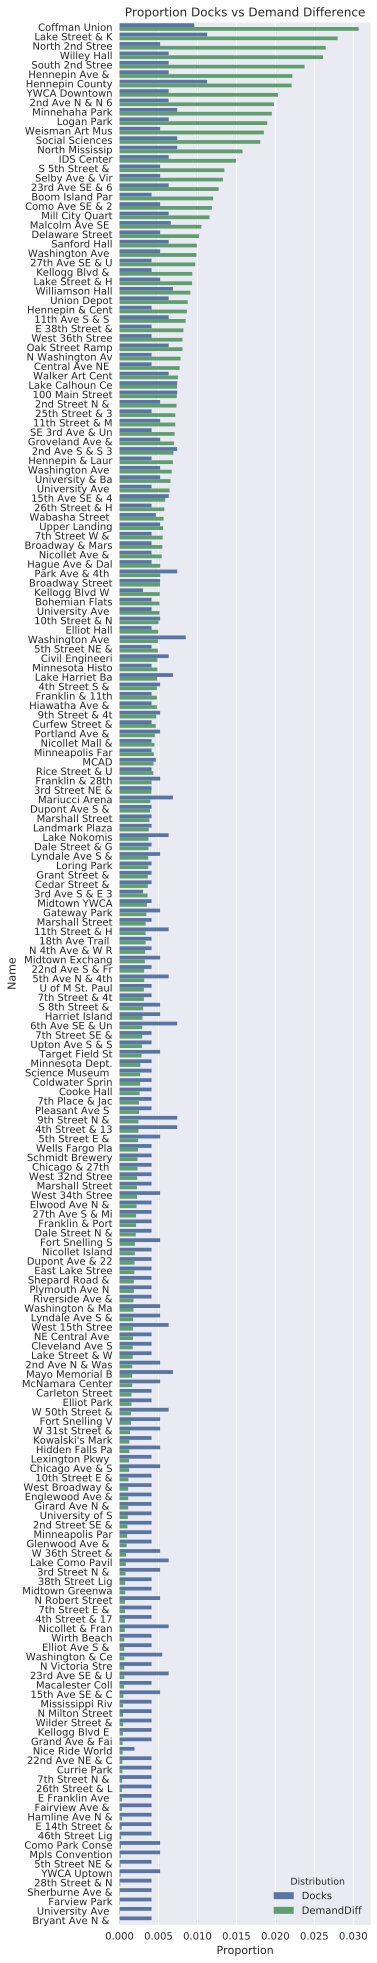

In [57]:
# Compute the ABSOLUTE difference between #incoming and #outgoing trips
sdf['abs_diff'] = sdf['demand_diff'].abs()

# Distributions of docks and absolute demand difference across stations
sdf['Docks'] = sdf['Total docks']/sdf['Total docks'].sum()
sdf['DemandDiff'] = sdf['abs_diff']/sdf['abs_diff'].sum()

# Demand direction (more outgoing vs incoming)
sdf['demand_dir'] = sdf['Name']
sdf.loc[sdf['demand_diff']<0, 'demand_dir'] = 'More Outgoing'
sdf.loc[sdf['demand_diff']>0, 'demand_dir'] = 'More Incoming'
sdf.loc[sdf['demand_diff']==0, 'demand_dir'] = 'Balanced'

# Tidy the data for seaborn
tidified = (
    sdf[['Name', 'Docks', 'DemandDiff']]
       .set_index('Name')
       .stack()
       .reset_index()
       .rename(columns={'level_1': 'Distribution', 0: 'Proportion'})
)

# Show the distributions
plt.figure(figsize=(4.5, 35))
station_list = sdf.sort_values('DemandDiff', ascending=False)['Name'].tolist()
sns.barplot(y='Name', x='Proportion', hue='Distribution', data=tidified,
            order=station_list)
plt.title('Proportion Docks vs Demand Difference')
locs, labels = plt.yticks()
plt.yticks(locs, tuple([s[:15] for s in station_list]))
plt.show()

There's not a really good match between the number of docks at each station and the overall difference in demand.  But don't go telling Nice Ride to re-allocate their docks just yet!  Keep in mind that we were looking at the *overall* difference in demand - but that difference in demand probably changes over time.  For example, some stations may have more outbound trips in the morning and more inbound trips in the evening, or vice-versa.

Let's look at how the demand at each station changes over time.  First we need to compute the number of inbound and outbound trips, and the difference, at each station by the hour:

In [101]:
# Compute hourly trips at each station
trips['Start hour'] = trips['Start date'].dt.hour
trips['End hour'] = trips['End date'].dt.hour
outbound = ( #num trips in and out by hour for each station
    trips.groupby(['Start station', 'Start hour'])['Start date']
         .count().to_frame().reset_index()
         .rename(columns={"Start date": "Outbound trips", 
                          "Start station": "Station name",
                          "Start hour": "Hour"})
)
inbound = ( #num trips in and out by hour for each station
    trips.groupby(['End station', 'End hour'])['End date']
         .count().to_frame().reset_index()
         .rename(columns={"End date": "Inbound trips", 
                          "End station": "Station name",
                          "End hour": "Hour"})
)
trips_h = ( #num trips in and out by hour for each station
    pd.merge(outbound, inbound, how='outer', 
             on=['Station name', 'Hour'])
      .fillna(value=0)
      .sort_values(['Station name', 'Hour'])
)
trips_h['Difference'] = trips_h['Inbound trips'] - trips_h['Outbound trips']

# Pivot to get Nstations-by-Nhours arrays for in, out, and diff
trips_hp = trips_h.pivot(index='Station name', columns='Hour').fillna(value=0)

Now we can see how the demand at each station changes over time.  For example, let's take a look at the busy downtown station at the Hennepin County Government Center.

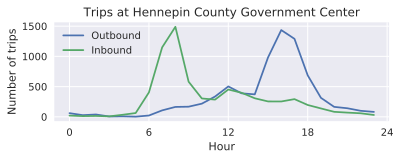

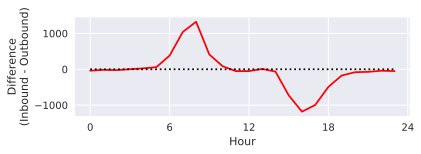

In [116]:
station_name = 'Hennepin County Government Center'

# Plot demand at Hennepin County Government Center
plt.figure()
plt.subplot(2, 1, 1)
inds = trips_h['Station name']==station_name
plt.plot(trips_h.loc[inds,'Hour'], 
         trips_h.loc[inds,'Outbound trips'])
plt.plot(trips_h.loc[inds,'Hour'], 
         trips_h.loc[inds,'Inbound trips'])
plt.xticks(np.arange(0, 25, 6))
plt.xlabel('Hour')
plt.ylabel('Number of trips')
plt.legend(['Outbound', 'Inbound'])
plt.title('Trips at '+station_name)
plt.show()

# Plot difference in demand at Lake Street & Knox Ave S
plt.subplot(2, 1, 2)
inds = trips_h['Station name']==station_name
plt.plot(trips_h.loc[inds,'Hour'], 
         trips_h.loc[inds,'Difference'], 'r')
plt.plot([0, 23], [0, 0], 'k:')
plt.xticks(np.arange(0, 25, 6))
plt.xlabel('Hour')
plt.ylabel('Difference\n(Inbound - Outbound)')
plt.show()

This station sees a large volume of both inbound and outbound rentals over the course of a day.  But the balance between inbound and outbound trips isn't constant - it changes with time!  At around 8am, there are more people ending their rentals at the station, probably people who are commuting to work.  But at the end of the day, around 5p, people are usually *starting* their rentals from that station, probably for their commute home.

What about a station in a more residential area?  Let's take a look at how the demand changes for a station in the Marcy Holmes neighborhood, just across the river from downtown, and down the street from the University of Minnesota.

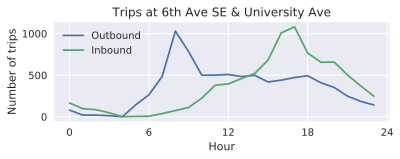

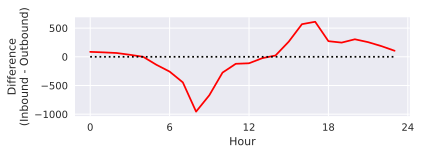

In [117]:
station_name = '6th Ave SE & University Ave'

# Plot demand at 6th Ave SE & University Ave
plt.figure()
plt.subplot(2, 1, 1)
inds = trips_h['Station name']==station_name
plt.plot(trips_h.loc[inds,'Hour'], 
         trips_h.loc[inds,'Outbound trips'])
plt.plot(trips_h.loc[inds,'Hour'], 
         trips_h.loc[inds,'Inbound trips'])
plt.xticks(np.arange(0, 25, 6))
plt.xlabel('Hour')
plt.ylabel('Number of trips')
plt.legend(['Outbound', 'Inbound'])
plt.title('Trips at '+station_name)
plt.show()

# Plot difference in demand at Lake Street & Knox Ave S
plt.subplot(2, 1, 2)
inds = trips_h['Station name']==station_name
plt.plot(trips_h.loc[inds,'Hour'], 
         trips_h.loc[inds,'Difference'], 'r')
plt.plot([0, 23], [0, 0], 'k:')
plt.xticks(np.arange(0, 25, 6))
plt.xlabel('Hour')
plt.ylabel('Difference\n(Inbound - Outbound)')
plt.show()

Here the pattern is the opposite - more trips depart from the station in the morning and end there in the afternoon.  There's also a lot more inbound trips late into the evening.  That's probably students from the Univeristy of Minnesota coming home.

But instead of looking through all 202 stations individually, let's just plot on a map how the difference in demand changes across the day at all stations.  In the map below, drag the slider to see how station demands change over the course of the day.

(Note: you might want to pan the map a bit before messing with the slider.  It gets a bit glitchy otherwise.)

In [128]:
def HourSlider(loc, val, title='', height=500, width=800,
               palette=Viridis256, symmetric_color=False):
    """Plot map of points w/ values which change hourly
    
    Parameters
    ----------
    loc : pd.DataFrame
        Locations and names of stations.
        Must have Name, Latitude, and Longitude columns
        Size: (Nstations, 3)
    val : pd.DataFrame
        Values which change hourly
        Size: (Nstations, Nhours)
        
    Returns
    -------
    bokeh.models.layouts.Column
    Bokeh layout with the plot and slider
    """
    
    # On hover, show station name
    tooltips = [("Station", loc.Name)]

    # Plot trips
    V = np.transpose(val.values)
    p, src = MapPoints(loc.Latitude, loc.Longitude, 
                       tooltips=tooltips, color=V[12,:],
                       size=0.7*np.sqrt(np.abs(V[12,:])),
                       symmetric_color=symmetric_color,
                       palette=palette, title=title, 
                       height=height, width=width)
    
    # Make slider to control hour
    cb = CustomJS(args=dict(source=src, colors=V), code="""
        var h = cb_obj.value;
        var c = source.data['color'];
        var s = source.data['size'];
        for (var i = 0; i < c.length; i++) {
            c[i] = colors[h][i];
            s[i] = 0.7*Math.sqrt(Math.abs(colors[h][i]));
        }
        source.change.emit();
    """)
    slider = Slider(start=0, end=23, 
                    value=12, step=1, title="Hour")
    slider.js_on_change('value', cb)
    
    # Return figure w/ slider
    return column(p, slider)

# Outbound
p1 = HourSlider(stations.sort_values('Name'), 
                trips_hp['Outbound trips'], 
                title='Number of Outbound Trips, by Hour')
tab1 = Panel(child=p1, title="Outbound")

# Inbound
p2 = HourSlider(stations.sort_values('Name'), 
                trips_hp['Inbound trips'], 
                title='Number of Inbound Trips, by Hour')
tab2 = Panel(child=p2, title="Inbound")

# Difference
p3 = HourSlider(stations.sort_values('Name'), 
                trips_hp['Difference'], 
                title='Difference (Inbound - Outbound), by Hour',
                palette=brewer['Spectral'][11],
                symmetric_color=True)
tab3 = Panel(child=p3, title="Difference")

# Show all tabs
show(Tabs(tabs=[tab3, tab1, tab2]))

TODO: talk about the clear commute trend

# Notes / TODO

## Demand

...

Talk about how for stations which don't have a good match of # docks to demand diff, they'll need to redistribute bikes more actively there.  And they don't have that data (when bikes are moved where) in their historical dataset, but you could figure it out from their data feed https://api-core.niceridemn.org/gbfs/gbfs.json
But we can still see which stations will need to have bikes distributed (and in what direction) when

plot cumulative difference for an example station

image plot of CUMULATIVE difference in demand (maybe 2 separate ones for weekday/weekend)
X is time of day
Y is station
color indicates cumulative difference in demand

Find the optimal "starting # of bikes" at each station which gives best balance between in + out demand
take mean of the cumulative difference in demand vals (so if >0 that means on avg more bikes are coming IN, and you should start w/ LESS bikes @ that station), then set the optimal # of bikes to start a day w/ at that station as:
optStartVal = 0.5 x (num docks at that station) - (mean of cum diff in demand) 
but limit to num docks: optStartVal = max(0, min( optStartVal,  numDocksAtStation ) )

Then do another color plot: normalize by # docks (so 0 is when optStartVal + cum diff in demand is less than 0, and 1 when optStartVal + cum diff in demand is greater than the num docks)
then highlight (make custom color map) when the expected num bikes goes below 0 or above num docks (above normalized value of 1)!
Sort by ... somehow
so you can see which docks NEED re-allocation and when


## Flow

Flow Bokeh plot
- show flow on station hover
- Have Radio Button Group for [All, M-Th, F, Sat, Sun] 
- And a slider for hour of the day
- Talk about interesting differences(Eg to/from downtown on a weekday morning vs night, Or to/from the lakes/parks weekday vs weekend)
  
Compute # bikes at each station? If that's not provided
- Then visualize bike availability vs station

## Memberships

Basic hist of memberships

Is there a difference in the bike patterns between rides by people with a membership vs people without one?
- Compute the transition (or trip) probability matrix for members and separately for non members
- Does it significantly differ?
- Or could bootstrap to get distributions for each trip, compute roc to get prob members take that trip more often (don't bother with significance testing unless there's one or two you are really interested in...)
- Then find the M best stations to put ads at (the M stations which maximize the probability that a person with a riding pattern similar to people with memberships will see it)
- Mention that this assumes that people who have bike patterns that are similar to those people with memberships are more likely to actually get memberships. And say that in fact what you would really want to do is do a/b testing or Bandit algorithm.

## Ride durations

? but look at that.  at least a histogram.

## Ride season

Look at number of rides over the course of a year.
Talk about "do people ride less in the spring/fall just beacause, or because the weather isn't as nice?"

## Weather

How does riding activity depend on the weather?
 -Temperature, cloudy, and rain
 
 ## Seasonal dependence
 
 "now that we have the weather data, we can get back to our question of why people ride less in the beginning/end of a season"
Is there a seasonal dependence in riding activity independent of the weather?
- Look at residuals over season after regressing out weather
- The idea is: do people just not wanna ride bikes as much in the fall even if it's nice out?
- And talk about how the idea is to in a later post see if it would be profitable to keep their season going longer

BTW i'd predict that riding activity, after controlling for weather, actually ramps up over the course of a season.
which would mean it wouldn't be profitable to open *earlier* but it **would** be profitable to extend the riding season further into the fall.

## Other

Take a look at other rideshare EDAs for inspiration

